In [ ]:
import lib
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# augmentation of image + mask
for i in range(1,35):
    imagepath="segmented/im"+str(i)+".png"
    maskpath="segmented/mask"+str(i)+".png"
    img_prefix="im"+str(i)
    mask_prefix="mask"+str(i)
    save_to_dir="augmented/"
    nr=101
    size=[96,96]
    
    lib.augment(imagepath=imagepath, maskpath=maskpath, img_prefix=img_prefix, mask_prefix=mask_prefix, save_to_dir=save_to_dir, nr=nr, size=size)

In [ ]:
# create training images
folder = "augmented/"
images = lib.createimgs(folder)
masks = lib.createmasks(folder)

In [ ]:
# create and train model
model = lib.train(imgs_train=images, imgs_mask_train=masks, epochs=15, lr=1e-4, batch_size=2)

In [ ]:
imgs_test = lib.createimgs(pathdir="testseg/",startswith="C")

imgs_test = lib.preprocess(imgs_test)
imgs_test = imgs_test.astype('float32')

mean = np.mean(imgs_test)  # mean for data centering
std = np.std(imgs_test)  # std for data normalization

imgs_test -= mean
imgs_test /= std

pred = model.predict(imgs_test)

for i in range(imgs_test.shape[0]): 
    plt.imshow((imgs_test[i,:,:,0]), cmap='Greys_r')
    plt.show()
    plt.imshow((pred[i,:,:,0]), cmap='Greys_r')
    plt.show()
    imgs_test[i,:,:,0]=imgs_test[i,:,:,0] - (imgs_test[i,:,:,0]*pred[i,:,:,0])
    plt.imshow((imgs_test[i,:,:,0]),  cmap='Greys_r')
    plt.show()


In [ ]:
imgs_test = lib.createimgs(pathdir="testseg/",startswith="C")

imgs_test = lib.preprocess(imgs_test)
imgs_test = imgs_test.astype('float32')

mean = np.mean(imgs_test)  # mean for data centering
std = np.std(imgs_test)  # std for data normalization

imgs_test -= mean
imgs_test /= std

pred = model.predict(imgs_test)

for i in range(imgs_test.shape[0]): 
    plt.imshow((imgs_test[i,:,:,0]), cmap='Greys_r')
    plt.show()
    plt.imshow((pred[i,:,:,0]), cmap='Greys_r')
    plt.show()
    #res=imgs_test[i,:,:,0] - (imgs_test[i,:,:,0]*pred[i,:,:,0])
    print (imgs_test[i,:,:,:].shape)
    
    #rest = np.dstack((imgs_test[i,:,:,0],imgs_test[i,:,:,0]))
    plt.imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    plt.axis('off')
    #res = np.reshape(res, (96,96,4))
    res = pred[i,:,:,0]
    res [ res<=0.9 ] = np.nan
    plt.savefig('results/foo'+str(0)+str(i)+'png')
    plt.imshow(pred[i,:,:,0],  alpha=0.5, cmap='Reds')
    
    plt.savefig('results/foo'+str(i)+'png')
    plt.show()

In [ ]:
model.to_json("kerasmodelheartjson")

In [ ]:
np.c_[imgs_test[i,:,:,0],res,res].shape


In [ ]:
import keras
keras.models.load_model("kerasmodelheartseg2", custom_objects={'loss_max': dice_coef_loss(1, 2)})

In [1]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage.transform import resize

img_rows = 96
img_cols = 96

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def get_unet(lr=1e-4):
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=[dice_coef])

    return model

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

Using TensorFlow backend.


In [2]:
model2=get_unet()

model2.load_weights("kerasmodelheartweights")

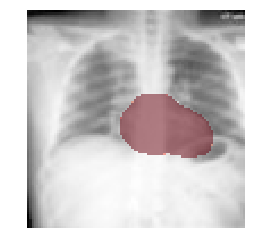

In [3]:
imgs_test = scipy.misc.imread("outfile.jpg")
imgs_test = scipy.misc.imresize(imgs_test[:,:,1], [96,96])
imgs_test = imgs_test[..., np.newaxis]
imgs_test = imgs_test[np.newaxis, ...]
imgs_test = imgs_test.astype('float32')

mean = np.mean(imgs_test)  # mean for data centering
std = np.std(imgs_test)  # std for data normalization

imgs_test -= mean
imgs_test /= std

pred = model2.predict(imgs_test)

plt.imshow(imgs_test[0,:,:,0], cmap='Greys_r')
plt.axis('off')
res = pred[0,:,:,0]
res [ res<=0.9 ] = np.nan
plt.savefig('raw.png')
plt.imshow(pred[0,:,:,0],  alpha=0.5, cmap='Reds') 
plt.savefig('heart.png')


plt.show()